# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on a causal discovery algorithm and create high-quality plots of the results.
This tutorial explains the main features and gives walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Nonlinear conditional independence tests
4. Symbolic time series
5. Causal assumptions
6. Missing values and masking
7. Parallization
8. PCMCI vs Granger causality
9. Causal effects and mediation
10. Optimal predictor selection

## 1. Basic usage

In [1]:
# Imports
import numpy
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [2]:
numpy.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object
dataframe = pp.DataFrame(data)

# Specify time axis and variable names
datatime = numpy.arange(len(data))
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']

First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

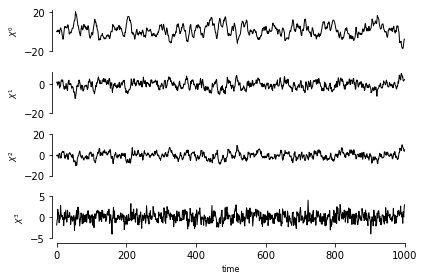

In [3]:
tp.plot_timeseries(data, datatime, var_names)

It's stationary and doesn't contain missing values (covered below). Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` method with  ``dataframe``, ``cond_ind_test``, and (optionally) ``var_names``:

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=1)

Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.


## Estimating lagged dependencies


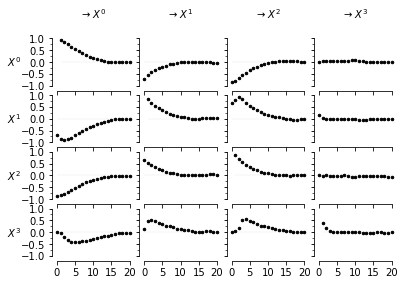

In [5]:
correlations = pcmci.get_lagged_dependencies(tau_max=20)
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, var_names=var_names, 
                                    x_base=5, y_base=.5)

Since the dependencies decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for the causal algorithm. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``).

In [6]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

## Variable $X^1$

## Variable $X^2$

## Variable $X^3$

## Resulting condition sets:

    Variable $X^0$ has 6 parent(s):
    [pc_alpha = 0.3]
        ($X^0$ -1): max_pval = 0.00000, min_val = 0.796
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.748
        ($X^3$ -2): max_pval = 0.13715, min_val = 0.048
        ($X^2$ -1): max_pval = 0.19384, min_val = 0.042
        ($X^3$ -7): max_pval = 0.25822, min_val = 0.036
        ($X^1$ -4): max_pval = 0.26548, min_val = 0.036

    Variable $X^1$ has 4 parent(s):
    [pc_alpha = 0.3]
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.695
        ($X^3$ -1): max_pval = 0.00000, min_val = 0.484
        ($X^3$ -7): max_pval = 0.14660, min_val = 0.046
        ($X^2$ -1): max_pval = 0.22144, min_val = 0.039

    Variable $X^2$ has 

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations), and optionally its confidence bounds (can be specified upon initializing ``ParCorr``). ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$. Per default, the MCI values for $\tau=0$ are not evaluated (can be changed with ``tau_min`` argument).

In [7]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[ 1.     0.     0.286  0.907  0.849  0.035  0.418  0.265  0.939]
  [ 1.     0.296  0.089  0.738  0.541  0.24   0.234  0.825  0.956]
  [ 1.     0.652  0.446  0.01   0.441  0.465  0.837  0.256  0.391]
  [ 1.     0.649  0.488  0.559  0.617  0.928  0.791  0.895  0.806]]

 [[ 1.     0.     0.153  0.491  0.047  0.005  0.554  0.543  0.37 ]
  [ 1.     0.     0.911  0.07   0.576  0.556  0.175  0.732  0.741]
  [ 1.     0.711  0.     0.242  0.486  0.417  0.424  0.944  0.224]
  [ 1.     0.171  0.088  0.989  0.965  0.859  0.915  0.43   0.671]]

 [[ 1.     0.108  0.188  0.517  0.344  0.258  0.974  0.917  0.547]
  [ 1.     0.072  0.603  0.396  0.886  0.765  0.696  0.397  0.64 ]
  [ 1.     0.     0.069  0.92   0.95   0.624  0.814  0.534  0.86 ]
  [ 1.     0.571  0.343  0.632  0.599  0.669  0.818  0.054  0.87 ]]

 [[ 1.     0.03   0.093  0.55   0.701  0.194  0.393  0.095  0.869]
  [ 1.     0.     0.558  0.534  0.72   0.284  0.798  0.016  0.162]
  [ 1.     0.114  0.75   0.     0.987  0.095  0

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. At a chosen significance level the detected parents of each variable can then be printed:

In [8]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci._print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.651
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.565

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.663
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.622

    Variable $X^2$ has 3 link(s):
        ($X^3$ -3): pval = 0.00000 | qval = 0.00000 | val = 0.461
        ($X^1$ -2): pval = 0.00000 | qval = 0.00000 | val = 0.444
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.425

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.372


## 2. Plotting

Tigramite currently offers three plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the boolean ``link_matrix`` which denotes significant links by ``1``.

In [9]:
link_matrix = pcmci._return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

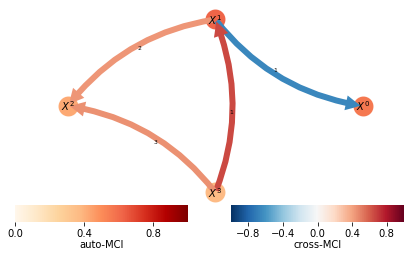

In [10]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )

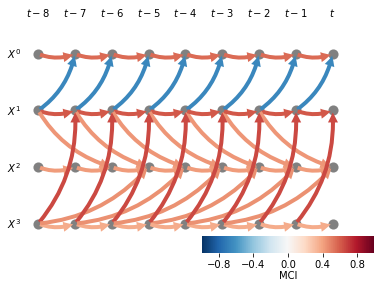

In [11]:
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

## 3. Nonlinear conditional independence tests

If nonlinear dependencies are present, it is advisable to use a nonparametric test. Consider the following model:

\begin{align*}
    X^0_t &= 0.2 (X^1_{t-1})^2 + \eta^0_t\\
    X^1_t &= \eta^1_t \\
    X^2_t &= 0.3 (X^1_{t-2})^2 + \eta^2_t
\end{align*}

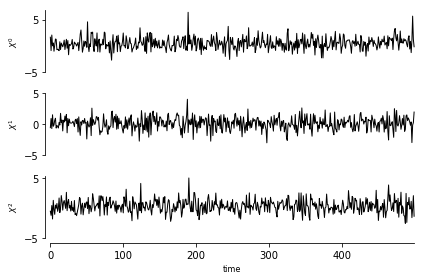

In [12]:
numpy.random.seed(1)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

In [13]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.234


``ParCorr`` here fails in two ways: (1) It cannot detect the two nonlinear links, (2) it wrongly detects a link $X^0_{t-1} \to X^2_t$ because it also cannot *condition out* a nonlinear dependency.

### GPDC

Tigramite covers nonlinear additive dependencies with a test based on *Gaussian process* regression and a *distance correlation* (``GPDC``) or *maximal correlation* (``GPACE``) on the residuals. Here we demonstrate GPDC since GPACE requires an R-package. For GPDC no analytical null distribution is available. One can either use a computationally expensive shuffle test throughout or the null distribution can be pre-computed for different anticipated sample sizes with ``generate_and_save_nulldists`` and stored to disk (could be run overnight:). Then ``significance='analytic'`` loads this file. If no file is given, the distribution is generated and stored in cache. GP regression is performed with ``sklearn`` default parameters, except for the *kernel* which here defaults to the radial basis function + a white kernel (both hyperparameters are internally optimized) and the assumed noise level ``alpha`` which is set to zero since we added a white kernel. These and other parameters can be set via the ``gp_params`` dictionary. See the documentation in ``sklearn`` for further discussion.

In [14]:
gpdc = GPDC(significance='analytic', gp_params=None)
# gpdc.generate_and_save_nulldists(sample_sizes=range(495, 501),
#     null_dist_filename='dc_nulldists.npz')
gpdc.null_dist_filename ='dc_nulldists.npz'
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    var_names=var_names,
    verbosity=0)

In contrast to ParCorr, the nonlinear links are correctly detected with GPDC:

In [15]:
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1)
pcmci_gpdc._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.030

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^1$ -2): pval = 0.00000 | val = 0.028


As a short excursion, we can see how GPDC works looking at the scatter plots:

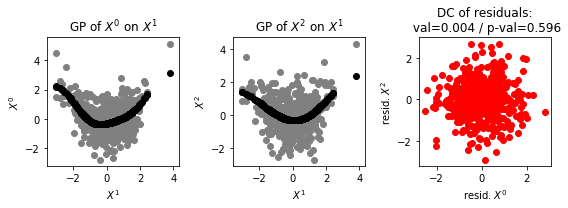

In [16]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red')
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

Let's look at some even more nonlinear dependencies in a model with multiplicative noise:

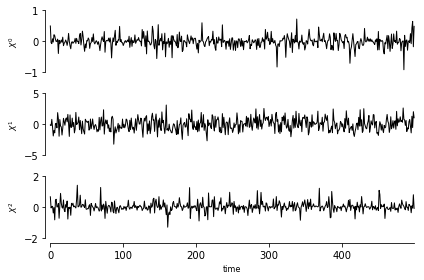

In [17]:
numpy.random.seed(42)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] *= 0.2*data[t-1, 1]
    data[t, 2] *= 0.3*data[t-2, 1]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

Since multiplicative noise violates the assumption of additive dependencies underlying GPDC, the spurious link  $X^0_{t-1} \to X^2_t$ is wrongly detected because it cannot be *conditioned out*. In contrast to ParCorr, however, the two true links *are* detected because DC detects any kind of dependency:

In [18]:
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    var_names=var_names)
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1)
pcmci_gpdc._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.034

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val = 0.025
        ($X^0$ -1): pval = 0.00400 | val = 0.018


### CMIknn

The most general conditional independence test implemented in Tigramite is CMIknn based on conditional mutual information estimated with a k-nearest neighbor estimator. CMIknn involves no assumptions about the dependencies. The parameter ``knn`` determines the size of hypercubes, ie., the (data-adaptive) local length-scale. Now we cannot even pre-compute the null distribution because CMIknn is not residual-based like GPDC and the nulldistribution depends on many more factors. We, therefore, use ``significance='shuffle_test'`` to generate it in each individual test. The following cell may take some minutes.

In [19]:
# cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5)
# pcmci_cmi_knn = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=cmi_knn,
#     var_names=var_names,
#     verbosity=2)
# results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05)
# pcmci_cmi_knn._print_significant_links(
#         p_matrix = results['p_matrix'], 
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

In [20]:
## Significant links at alpha = 0.01:

#     Variable $X^0$ has 1 link(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.108

#     Variable $X^1$ has 0 link(s):

#     Variable $X^2$ has 1 link(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.080

Here CMIknn correctly detects the true links and also unveils the spurious link. While CMIknn may now seem as the best independence test choice, we have to note that the generality comes at the cost of much lower power for the case that the dependencies actually follow some parametric form. Then ParCorr or GPDC are much more powerful measures. Of course, ParCorr also detects linear links better than GPDC. 

## 4. Symbolic time series

Symbolic (or discrete) data may arise naturally or continuously-valued time series can be converted to symbolic data. To accommodate such time series, Tigramite includes the ``CMIsymb`` conditional independence test based on conditional mutual information estimated directly from the histogram of discrete values. Usually a (quantile-)binning  applied to continuous data in order to use a discrete CMI estimator is not recommended (rather use ``CMIknn``), but here we do it anyway to get some symbolic data. We again consider the nonlinear time series example and convert to a symbolic series with 4 bins.

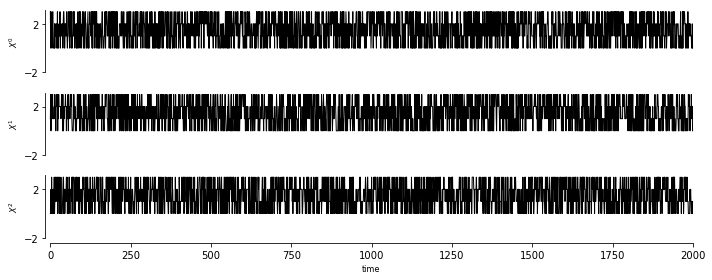

In [21]:
numpy.random.seed(1)
data = numpy.random.randn(2000, 3)
for t in range(1, 2000):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
data = pp.quantile_bin_array(data, bins=4)
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, figsize=(10,4), var_names=var_names)

CMIsymb is initialized with ``n_symbs=None`` implying that the number of symbols is determined as ``n_symbs=data.max()+1``. Again, we have to use a shuffle test. Symbolic CMI works not very well here, only for 2000 samples was the correct graph reliably detected.

In [22]:
# cmi_symb = CMIsymb(significance='shuffle_test', n_symbs=None)
# pcmci_cmi_symb = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=cmi_symb,
#     var_names=var_names)
# results = pcmci_cmi_symb.run_pcmci(tau_max=2, pc_alpha=0.2)
# pcmci_cmi_symb._print_significant_links(
#         p_matrix = results['p_matrix'], 
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

In [23]:
## Significant parents at alpha = 0.01:

#     Variable $X^0$ has 1 parent(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.040

#     Variable $X^1$ has 0 parent(s):

#     Variable $X^2$ has 1 parent(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.036

## 5. Causal assumptions

Having introduced the basic functionality, we now turn to a discussion of the assumptions underlying a causal interpretation:

  - **Faithfulness / Stableness:** *Independencies in data arise not from incredible coincidence, but rather from causal structure.*
  
  - **Causal Sufficiency:** *Measured variables include all of the common causes.*
  
  - **Causal Markov Condition:** *All the relevant probabilistic information that can be obtained from the system is contained in its direct causes.*
  
  - **No contemporaneous effects:** *Contemporaneous dependencies arise only from latent common drivers*
  
  - **Stationarity**
  
  - **Parametric assumptions of independence tests** (these where already discussed above)*

### Faithfulness

Faithfulness, as stated above, is an expression of the assumption that the independencies we measure come from the causal structure, i.e., the time series graph, and cannot occur due to some fine tuning of the parameters. Another unfaithful case are processes containing *purely* deterministic dependencies, i.e., $Y=f(X)$, without any noise. We illustrate these cases in the following.

#### Fine tuning

Suppose in our model we have two ways in which $X^0$ causes $X^2$, a direct one, and an indirect effect $X^0\to X^1 \to X^2$ as realized in the following model:

\begin{align*}
    X^0_t &= \eta^0_t\\
    X^1_t &= 0.6 X^0_{t-1} + \eta^1_t\\
    X^2_t &= 0.6 X^1_{t-1} - 0.36 X^0_{t-2} + \eta^2_t\\
\end{align*}

In [24]:
numpy.random.seed(1)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
#     data[t, 0] += 0.6*data[t-1, 1]
    data[t, 1] += 0.6*data[t-1, 0]
    data[t, 2] += 0.6*data[t-1, 1] - 0.36*data[t-2, 0]
dataframe = pp.DataFrame(data)
# tp.plot_timeseries(data, var_names=var_names)

Since here $X^2_t = 0.6 X^1_{t-1} - 0.36 X^0_{t-2} + \eta^2_t = 0.6 (0.6 X^0_{t-2} + \eta^1_{t-1}) - 0.36 X^0_{t-2} + \eta^2_t = 0.36 X^0_{t-2} - 0.36 X^0_{t-2} + ...$, there is no unconditional dependency $X^0_{t-2} \to X^2_t$ and the link is not detected in the condition-selection step: 

In [25]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
all_parents = pcmci_parcorr.run_pc_stable(tau_max=2, pc_alpha=0.2)
print ("Conditions:")
pcmci_parcorr._print_parents(all_parents, pcmci_parcorr.test_statistic_values, pcmci_parcorr.p_max)

Conditions:

    Variable $X^0$ has 0 parent(s):

    Variable $X^1$ has 1 parent(s):
        ($X^0$ -1): max_pval = 0.00000, min_val = 0.534

    Variable $X^2$ has 1 parent(s):
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.434


<tigramite.pcmci.PCMCI instance at 0x7efedf3c9908>

However, since the other parent of $X^2$, namely $X^1_{t-1}$ *is* detected, the MCI step conditions on $X^1_{t-1}$ and can reveal the true underlying graph:

In [26]:
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.536

    Variable $X^2$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.543
        ($X^0$ -2): pval = 0.00000 | val = -0.365


Note, however, that this is not always the case and parameter-fine tuning, even though a pathological case, can present a problem especially for smaller sample sizes.

#### Deterministic dependencies

Another violation of faithfulness can happen due to *purely* deterministic dependencies as shown here:

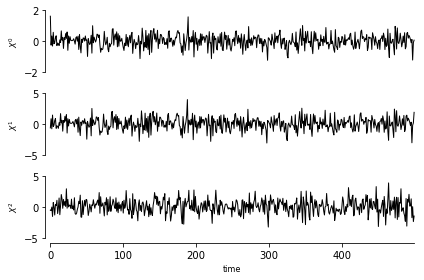

In [27]:
numpy.random.seed(1)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] = 0.4*data[t-1, 1]
    data[t, 2] += 0.3*data[t-2, 1] + 0.7*data[t-1, 0]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

tigramite/independence_tests.py:1228: RuntimeWarning: divide by zero encountered in double_scalars
  trafo_val = value * numpy.sqrt(df / (1. - value**2))



## Significant links at alpha = 0.01:

    Variable $X^0$ has 3 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 1.000
        ($X^0$ -1): pval = 0.00000 | val = 0.708
        ($X^0$ -2): pval = 0.00000 | val = 0.489

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^1$ -2): pval = 0.00000 | val = 0.501


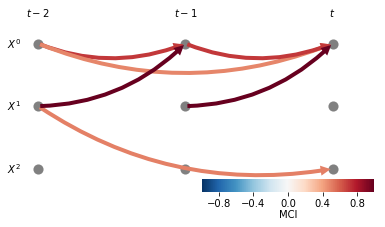

In [28]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

Here the partial correlation $X^1_{t-1} \to X^0_t$ is exactly 1. Since these now represent the same variable, the true link $X^0_{t-1} \to X^0_t$ cannot be detected anymore since we condition on $X^0_{t-2}$. Deterministic copies of other variables should be excluded from the analysis.

### Causal sufficiency

Causal sufficiency demands that the set of variables contains all common causes of any two variables. This is assumption is mostly violated when analyzing open complex systems outside a confined experimental setting. Any link estimated from a causal discovery algorithm could become non-significant if more variables are included in the analysis. 
Observational causal inference should generally be seen more as one step towards a physical process understanding. It can greatly help in an explorative model building analysis to get an idea of potential drivers. In particular, the absence of a link allows for a more robust conclusion: If there is no evidence for a statistical dependency, then a physical mechanism is less likely (assuming that the other assumptions hold).

#### Unobserved driver / latent variable

For the common driver process, consider that the common driver was not measured:

In [29]:
numpy.random.seed(1)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] += 0.6*data[t-1, 1]
    data[t, 2] += 0.7*data[t-2, 1]
# tp.plot_timeseries(data, var_names=var_names)
obsdata = data[:,[0,2]]
# tp.plot_timeseries(obsdata, var_names=[var_names[0], var_names[2]])
dataframe = pp.DataFrame(obsdata)

Then it is impossible here to detect that the link $X^0\to X^2$ is spurious.

In [30]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=[var_names[0], var_names[2]],
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.312


#### Solar forcing

In a geoscientific context, the solar forcing typically is a strong common driver of many processes. To remove this trivial effect, time series are typically anomalized, that is, the average seasonal cycle is subtracted. But one could also include the solar forcing explicitely as shown here via a sine wave for an artificial example. We've also made the time series more realistic by adding an auto-dependency on their past values.

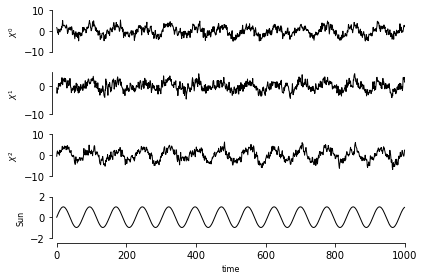

In [31]:
numpy.random.seed(1)
data = numpy.random.randn(1000, 4)
# Simple sun
data[:,3] = numpy.sin(numpy.arange(1000)*20/numpy.pi)
var_names[3] = 'Sun'
c = 0.8
for t in range(1, 1000):
    data[t, 0] += 0.4*data[t-1, 0] + 0.4*data[t-1, 1] + c*data[t-1,3]
    data[t, 1] += 0.5*data[t-1, 1] + c*data[t-1,3]
    data[t, 2] += 0.6*data[t-1, 2] + 0.3*data[t-2, 1] + c*data[t-1,3]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

If we do not account for the common solar forcing, there will be many spurious links:

In [32]:
parcorr = ParCorr()
dataframe_nosun = pp.DataFrame(data[:,[0,1,2]])
pcmci_parcorr = PCMCI(
    selected_variables = [0,1,2],
    dataframe=dataframe_nosun, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 3 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.420
        ($X^1$ -1): pval = 0.00000 | val = 0.403
        ($X^2$ -1): pval = 0.00027 | val = 0.116

    Variable $X^1$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.478
        ($X^0$ -1): pval = 0.00002 | val = 0.135

    Variable $X^2$ has 3 link(s):
        ($X^2$ -1): pval = 0.00000 | val = 0.559
        ($X^1$ -2): pval = 0.00000 | val = 0.197
        ($X^1$ -1): pval = 0.00274 | val = 0.095


However, if we explicitely include the solar forcing variable (which we assume is known in this case), we can identify the correct causal graph. Since we are not interested in the drivers of the solar forcing variable, we don't attempt to reconstruct its parents.


## Significant links at alpha = 0.01:

    Variable $X^0$ has 3 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.378
        ($X^1$ -1): pval = 0.00000 | val = 0.356
        (Sun -1): pval = 0.00707 | val = 0.085

    Variable $X^1$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.429
        (Sun -1): pval = 0.00000 | val = 0.258

    Variable $X^2$ has 4 link(s):
        ($X^2$ -1): pval = 0.00000 | val = 0.560
        (Sun -1): pval = 0.00000 | val = 0.309
        (Sun -2): pval = 0.00000 | val = 0.302
        ($X^1$ -2): pval = 0.00000 | val = 0.205


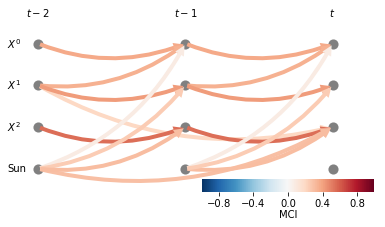

In [33]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    selected_variables = [0,1,2],
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

#### Time sub-sampling

Sometimes a time series might be sub-sampled, that is the measurements are less frequent than the true underlying time-dependency. Consider the following process:

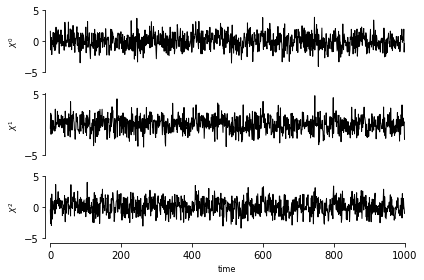

In [34]:
numpy.random.seed(1)
data = numpy.random.randn(1000, 3)
for t in range(1, 1000):
    data[t, 0] += 0.*data[t-1, 0] + 0.6*data[t-1,2]
    data[t, 1] += 0.*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.*data[t-1, 2] + 0.6*data[t-1,1]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

With the original time sampling we obtain the correct causal graph:

In [35]:
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(), var_names=var_names)
results = pcmci_parcorr.run_pcmci(tau_min=0,tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^2$ -1): pval = 0.00000 | val = 0.529

    Variable $X^1$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.515

    Variable $X^2$ has 1 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.532


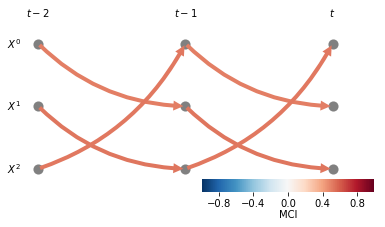

In [36]:
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

If we sub-sample the data, very counter-intuitive links can appear. The true causal loop gets detected in the wrong direction:

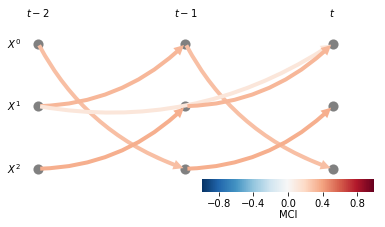

In [37]:
sampled_data = data[::2]
pcmci_parcorr = PCMCI(dataframe=pp.DataFrame(sampled_data), cond_ind_test=ParCorr(), 
                      var_names=var_names, verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_min=0, tau_max=2, pc_alpha=0.2)
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

If causal lags are smaller than the time sampling, such problems occur. Causal inference for sub-sampled data is still an active area of research.

### Causal Markov condition

The Markov condition can be rephrased as assuming that the noises driving each variable are independent of each other *and* independent in time (*iid*). This is violated in the following example where each variable is driven by *1/f* noise which refers to the scaling of the power spectrum. *1/f* noise can be generated by averaging AR(1) processes (http://www.scholarpedia.org/article/1/f_noise) which means that the noise is not independent in time anymore (even though the noise terms of each individual variable are still independent).

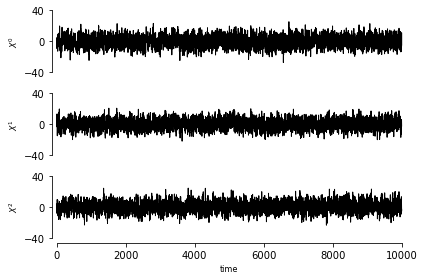

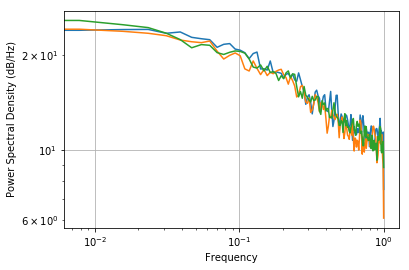

In [38]:
numpy.random.seed(1)
T = 10000
# Generate 1/f noise by averaging AR1-process with wide range of coeffs 
# (http://www.scholarpedia.org/article/1/f_noise)
def one_over_f_noise(T, n_ar=20):
    whitenoise = numpy.random.randn(T, n_ar)
    ar_coeffs = numpy.linspace(0.1, 0.9, n_ar)
    for t in range(T):
        whitenoise[t] += ar_coeffs*whitenoise[t-1]       
    return whitenoise.sum(axis=1)

data = numpy.random.randn(T, 3)
data[:,0] += one_over_f_noise(T)
data[:,1] += one_over_f_noise(T)
data[:,2] += one_over_f_noise(T)

for t in range(1, T):
    data[t, 0] +=  0.4*data[t-1, 1] 
    data[t, 2] +=  0.3*data[t-2, 1] 
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)
plt.psd(data[:,0],return_line=True)[2]
plt.psd(data[:,1],return_line=True)[2]
plt.psd(data[:,2],return_line=True)[2]
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')

Here PCMCI will detect many spurious links, especially auto-dependencies, since the process has *long memory* and the present state is *not* independent of the further past given some set of parents. 

In [39]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=5, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 7 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.470
        ($X^1$ -1): pval = 0.00000 | val = 0.388
        ($X^1$ -2): pval = 0.00000 | val = -0.183
        ($X^0$ -2): pval = 0.00000 | val = 0.100
        ($X^1$ -3): pval = 0.00000 | val = -0.096
        ($X^1$ -4): pval = 0.00193 | val = -0.031
        ($X^0$ -3): pval = 0.00202 | val = 0.031

    Variable $X^1$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.468
        ($X^1$ -2): pval = 0.00000 | val = 0.065

    Variable $X^2$ has 8 link(s):
        ($X^2$ -1): pval = 0.00000 | val = 0.468
        ($X^1$ -2): pval = 0.00000 | val = 0.288
        ($X^1$ -3): pval = 0.00000 | val = -0.145
        ($X^2$ -2): pval = 0.00000 | val = 0.082
        ($X^1$ -4): pval = 0.00000 | val = -0.076
        ($X^2$ -3): pval = 0.00018 | val = 0.037
        ($X^0$ -1): pval = 0.00696 | val = 0.027
        ($X^0$ -5): pval = 0.00831 | val = 0.026


#### Time aggregation

An important choice is how to aggregate measured time series. For example, climate time series might have been measured daily, but one might be interested in a less noisy time-scale and analyze monthly aggregates. Consider the following process:

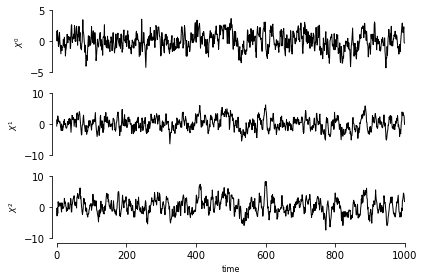

In [40]:
numpy.random.seed(1)
data = numpy.random.randn(1000, 3)
for t in range(1, 1000):
    data[t, 0] += 0.7*data[t-1, 0] 
    data[t, 1] += 0.6*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.5*data[t-1, 2] + 0.6*data[t-1,1]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

With the original time aggregation we obtain the correct causal graph:

In [41]:
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(), var_names=var_names)
results = pcmci_parcorr.run_pcmci(tau_min=0,tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.574

    Variable $X^1$ has 2 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.514
        ($X^1$ -1): pval = 0.00000 | val = 0.512

    Variable $X^2$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.534
        ($X^2$ -1): pval = 0.00000 | val = 0.440


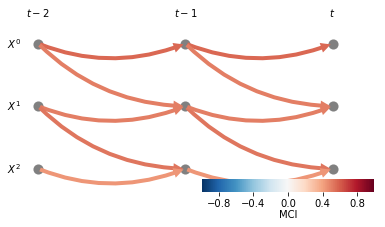

In [42]:
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

If we aggregate the data, we also detect a contemporaneous dependency for which no causal direction can be assessed in this framework and we obtain also several lagged spurious links. Essentially, we now have direct causal effects that appear contemporaneous on the aggregated time scale. Also causal inference for time-aggregated data is still an active area of research.

In [43]:
aggregated_data = pp.time_bin_with_mask(data, time_bin_length=4)
pcmci_parcorr = PCMCI(dataframe=pp.DataFrame(aggregated_data[0]), cond_ind_test=ParCorr(), 
                      var_names=var_names, verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_min=0, tau_max=2, pc_alpha=0.2)
# pcmci_parcorr._print_significant_links(
#         p_matrix = results['p_matrix'], 
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

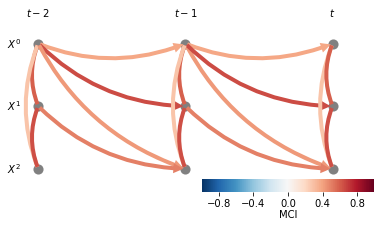

In [44]:
link_matrix = pcmci_parcorr._return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )

## Missing values and masking

### Missing values

Tigramite consistently handles missing values. For example, missing values denoted as ``999.`` in the data can be flagged with ``ParCorr.set_dataframe(data, missing_flag=999.)``. Then all time slices of samples where missing values occur in any variable are dismissed while consistently handling time lags. To avoid biases also subsequent samples for all lags up to ``2*tau_max`` are dismissed, see section on masking in Supplement of description paper. 

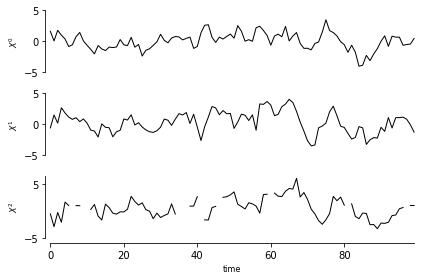


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = 0.2
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/6):
            Constructed array of shape (2, 58) from
            X = [(0, -1)]
            Y = [(0, 0)]
            Z = []
            with missing values labeled 999.0 removed
    Combination 1:  --> pval = 0.00000 / val = 0.682
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/6):
            Constructed array of shape (2, 58) from
            X = [(0, -2)]
            Y = [(0, 0)]
            Z = []
            with missing values labeled 999.0 removed
    Combination 1:  --> pval = 0.00002 / val = 0.532
    No conditions of dimension 0 left.

    Link ($X^1$ -1) --> $X^0$ (3/6):
            Co

In [45]:
numpy.random.seed(1)
data = numpy.random.randn(100, 3)
for t in range(1, 100):
    data[t, 0] += 0.7*data[t-1, 0] 
    data[t, 1] += 0.6*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.5*data[t-1, 2] + 0.6*data[t-1,1]
# Randomly mark 30% of values as missing values in variable 2
data[numpy.random.permutation(100)[:10], 2] = 999.
tp.plot_timeseries(data, missing_flag=999., var_names=var_names)
dataframe = pp.DataFrame(data, missing_flag=999.)
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(verbosity=3), 
                      var_names=var_names, verbosity=4)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

### Masking

Different from missing values, masking can be used to include or exclude samples depending on the situation: For example, in climate research we frequently are interested to detect the drivers of a target variable *only in winter months*. Thus, in all independent tests $X \perp Y | Z$ carried out during a PCMCI analysis, we require samples of $Y$ to be from the winter only, while lagged samples of $X$ or $Z$ can also come from the previous summer. This can be achieved with ``mask_type='y'`` in initializing ``ParCorr``' and marking all winter month data in $Y$ in ``mask``. If we want *all* samples, also in $X$ and $Z$ to be restricted to winter months, we need to mark them in ``mask`` as well and set  ``mask_type='yxz'``. Correspondingly, also  ``mask_type='z'`` or any combination is possible. See the section on masking in the Supplement of the description paper for more details.

In the following example, we generate data with a different underlying causality for winter and summer months. In particular, assume a causal effect is of opposite sign in both seasons.

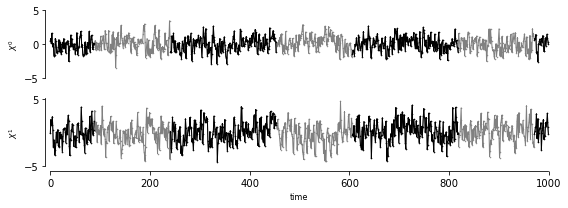

In [46]:
# Masking demo: We consider time series where the first half is generated by a different
# causal process than the second half. 
numpy.random.seed(42)
T = 1000
data = numpy.random.randn(T, 2)
data_mask = numpy.zeros(data.shape)
for t in range(1, T):
#     print t % 365
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.9*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] - 0.9*data[t-1, 0]

T, N = data.shape
# print data_mask[:100, 0]
dataframe = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(data, figsize=(8,3),  var_names=var_names, use_mask=True, mask=data_mask, 
                             grey_masked_samples='data')


In [47]:
# Setup analysis
def run_and_plot(cond_ind_test, fig_ax):
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, var_names=var_names)
    results = pcmci.run_pcmci(tau_max=2,pc_alpha=0.2, )
    link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix, var_names=var_names,
    )

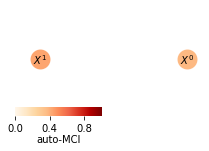

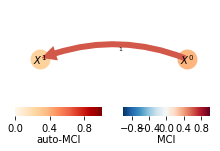

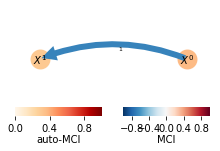

In [48]:
# Causal graph of whole year yields no link because effects average out
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(use_mask=False), (fig, ax))

# # Causal graph of winter half only gives positive link
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(use_mask=True, mask_type='y'), (fig, ax))

# Causal graph of summer half only gives negative link
fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
dataframe.mask = (dataframe.mask == False)
run_and_plot(ParCorr(use_mask=True, mask_type='y'),  (fig, ax))


Note, however, that the failure to detect the link on the whole sample occurs only for partial correlatiol because the positive and negative dependencies cancel out. Using CMIknn recovers the link (but gets a false positive for this realization):

In [59]:
# pcmci = PCMCI(dataframe=dataframe, cond_ind_test=CMIknn(use_mask=False), var_names=var_names)
# results = pcmci.run_pcmci(tau_max=2,pc_alpha=0.2)
# link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
#         val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# fig  = plt.figure(figsize=(3,2)); ax=fig.add_subplot(111)
# tp.plot_graph(fig_ax = (fig, ax),  val_matrix=results['val_matrix'],
#               link_matrix=link_matrix, var_names=var_names)

# 7. Parallelization

The repository also contains a script ``run_pcmci_parallel`` that parallelizes the tigramite PCMCI function. It requires ``mpi4py`` to be installed. The data and parameters can be set in the script itself which can be run from a shell with:

``$ mpirun -np 4 python run_pcmci_parallel.py``

Here ``-np 4`` specifies the number of cores available. This script can be run on multiple processors on a single machine or also on a cluster computer.

# 8. PCMCI vs One-step full conditioning aka Granger causality

An alternative way to estimate the time series graph is to directly test links by their defining equation

\begin{align*}
X^i_{t-\tau} \perp X^j_t ~|~ \mathbf{X}^-_t
\end{align*}

where $\mathbf{X}^-_t=(\mathbf{X}_{t-1}, \mathbf{X}_{t-2}, \ldots)$ is the past of the whole process. This is the approach of a *lag-specific* version of Granger causality (GC) or Transfer entropy. This approach gives lower detection power for two reasons:

1. Smaller *effect size* of GC compared to MCI
2. Higher dimensionality 

## 8.1 Smaller *effect size* of GC compared to MCI

Consider the following system:

\begin{align*} 
Z_t &= a Z_{t-1} + c_{XZ} X_{t-1} + \eta^Z_t  \\
X_t &= a_{X} X_{t-1} + c_{WX} W_{t-1} + \eta^X_t  \\
Y_t &= a Y_{t-1} + c_{XY} X_{t-2} + c_{WY} W_{t-3} + \eta^Y_t \\
W_t &= a W_{t-1} + \eta^W_t
\end{align*}

with independent Gaussian white noise processes $\eta^{\cdot}_t$ with variances $\sigma^2_{\cdot}$. Considering the link $X_{t-2}\to Y_t$, here it can be shown (see description paper) that the test statistic $I^{GC}(X_{t-2}\to Y_t) \leq I^{MCI}(X_{t-2}\to Y_t)$ generally. In the paper this is proven for arbitrary models. Measuring a smaller effect size implies a lower power to detect this particular link:

In [60]:
# Setup analysis
numpy.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.9), ((1, -2), -0.25)],
                1: [((1, -1), 0.95), ((3, -3), 0.3)],
                2: [((2, -1), 0.85), ((1, -2), 0.3), ((3, -3), 0.3)],
                3: [((3, -1), 0.9)],
                }
T = 100     # time series length
N = len(links_coeffs.keys())
tau_max = 5
realizations = 100
alpha_level = 0.05

var_names = [r'$Z$', r'$X$', r'$Y$', r'$W$']
# Define whole past
whole_past = {}
for j in range(N):
    whole_past[j] = [(var, -lag)
                         for var in range(N)
                         for lag in range(1, tau_max + 1)
                    ]
def get_sig_links():
    p_matrices = {'PCMCI':numpy.ones((realizations, N, N, tau_max+1)),
                  'GC':numpy.ones((realizations, N, N, tau_max+1))}
    val_matrices = {'PCMCI':numpy.zeros((realizations, N, N, tau_max+1)),
                  'GC':numpy.zeros((realizations, N, N, tau_max+1))}  
    for i in range(realizations):
        data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
        dataframe = pp.DataFrame(data)
        
        # PCMCI
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr())
        results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.2)
        p_matrices['PCMCI'][i] = results['p_matrix']
        val_matrices['PCMCI'][i] = results['val_matrix']

        # Condition on whole past
        results = pcmci.run_mci(tau_max=tau_max,parents=whole_past)
        p_matrices['GC'][i] = results['p_matrix']
        val_matrices['GC'][i] = results['val_matrix']

    # Get true positive rate (=power) and false positive rate 
    sig_links = {'PCMCI':(p_matrices['PCMCI'] <= alpha_level).mean(axis=0),
                  'GC':(p_matrices['GC'] <= alpha_level).mean(axis=0),}
    ave_val_matrices = {'PCMCI':val_matrices['PCMCI'].mean(axis=0),
                  'GC':val_matrices['GC'].mean(axis=0),}
    return sig_links, ave_val_matrices



In [61]:
sig_links, ave_val_matrices = get_sig_links()

We estimate how often a link was detected at the given ``alpha_level`` and plot this fraction as the width of the links while the average effect size for each link is given as the color:

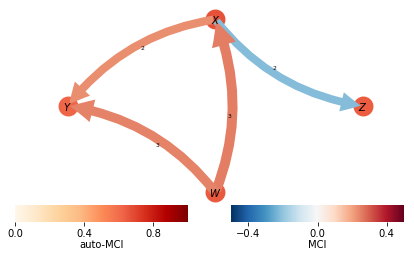

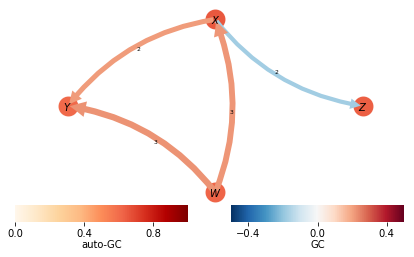

In [62]:
# Showing detection power as width of links
min_sig = 0.2
vminmax = 0.5
link_matrix = (sig_links['PCMCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['PCMCI'],
              link_matrix=link_matrix, var_names=var_names,
              link_width=sig_links['PCMCI'],
             arrow_linewidth=70.,
              vmin_edges=-vminmax,
              vmax_edges=vminmax,

)
link_matrix = (sig_links['GC'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['GC'],
              link_matrix=link_matrix, var_names=var_names,
              link_width=sig_links['GC'], 
              link_colorbar_label='GC',
              node_colorbar_label='auto-GC',
             arrow_linewidth=70.,
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
)

Evidently, the power of GC is lower mainly due to GC's test statistic effect size being smaller. MCI has been constructed to estimate a certain notion of *causal strength* as discussed in the paper. MCI, thus, alleviates the effect of other dependencies on a particular link. In large-scale studies, this feature allows to rank links by their causal strength.

## 8.2 Higher dimensionality 

An obvious drawback of GC is that it always includes the whole past as a condition leading to very high estimation dimension which results in lower power. In the following we consider a model with many irrelevant independent variables.

In [85]:
# Setup analysis
numpy.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.9), ((1, -2), -0.25)],
                1: [((1, -1), 0.95), ((3, -3), 0.3)],
                2: [((2, -1), 0.85), ((1, -2), 0.3), ((3, -3), 0.3)],
                3: [((3, -1), 0.9)],
                }
T = 80     # time series length
tau_max = 5
realizations = 100
alpha_level = 0.05
n_variables = 9

# Add independent variables
for d in range(4, n_variables):
    links_coeffs[d] = [((d, -1), 0.2 + numpy.random.rand()*0.7)]
    
var_names = [r'$Z$', r'$X$', r'$Y$', r'$W$'] + range(4, n_variables)

N = len(links_coeffs.keys())
# Define whole past
whole_past = {}
for j in range(N):
    whole_past[j] = [(var, -lag)
                         for var in range(N)
                         for lag in range(1, tau_max + 1)
                    ]

In [86]:
# This cell may take some minutes
sig_links, ave_val_matrices = get_sig_links()

/home/jakobrunge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less_equal


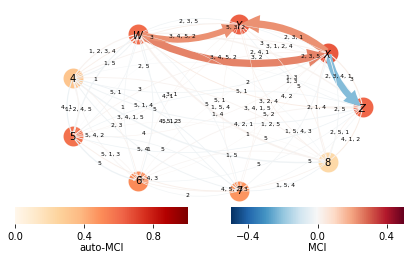

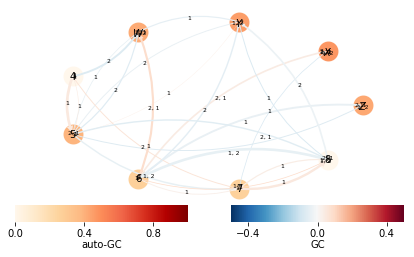

In [87]:
# Showing detection power as width of links
min_sig = 0.05
vminmax = 0.5
link_matrix = (sig_links['PCMCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['PCMCI'],
              link_matrix=link_matrix, 
              link_width=sig_links['PCMCI'],
             arrow_linewidth=70.,
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
              var_names = var_names,

)
link_matrix = (sig_links['GC'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['GC'],
              link_matrix=link_matrix, 
              link_width=sig_links['GC'], 
              link_colorbar_label='GC',
              node_colorbar_label='auto-GC',
             arrow_linewidth=70.,
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
             var_names = var_names,

)

Here adding just 5 independent variables makes it already impossible to detect the true links with GC, while PCMCI still detects them with almost the same power as before while still well controlling false positives at the expected 5% level (note that only 100 realizations were used to estimate the false positive rates making them not very reliable while the true positive rates are more reliable):

In [89]:
true_links = numpy.zeros((N, N, tau_max+1))
for var in links_coeffs.keys():
    for par in links_coeffs[var]:
        true_links[par[0][0], var, abs(par[0][1])] = True
# print true_links
print ("Mean true  positives PCMCI ", numpy.mean(sig_links['PCMCI'][:,:,1:]
                                                [true_links[:,:,1:]==True]).round(3))
print ("Mean false positives PCMCI ", numpy.mean(sig_links['PCMCI'][:,:,1:]
                                                [true_links[:,:,1:]==False]).round(3))
print ("Mean true  positives GC    ", numpy.mean(sig_links['GC'][:,:,1:]
                                                [true_links[:,:,1:]==True]).round(3))
print ("Mean false positives GC    ", numpy.mean(sig_links['GC'][:,:,1:]
                                                [true_links[:,:,1:]==False]).round(3))

('Mean true  positives PCMCI ', 0.77800000000000002)
('Mean false positives PCMCI ', 0.052999999999999999)
('Mean true  positives GC    ', 0.24199999999999999)
('Mean false positives GC    ', 0.021999999999999999)


# 9. Causal effects and mediation

The preceding sections were concerned with estimating causal links. In this section we discuss how the estimated time series graph can be used to evaluate causal effects and causal mediation in a linear framework as discussed in more detail in Runge et al, Nature Communications 2015. Consider the following model of a simple causal chain:

\begin{align*}
              X_t &= \eta^X_t \\
              Y_t &= 0.5 X_{t-1} +  \eta^Y_t \\
              Z_t &= 0.5 Y_{t-1} +  \eta^Z_t
\end{align*}

In [68]:
numpy.random.seed(42)
# links_coeffs = {0: [],
#                 1: [((0, -1), 0.5)],
#                 2: [((1, -1), 0.5)],
#                 }
links_coeffs = {0: [((0,-1), 0.8)],
                1: [((1,-1), 0.8), ((0, -1), 0.5)],
                2: [((2,-1), 0.8), ((1, -1), 0.5)],
                }
var_names = [r"$X$", r"$Y$", r"$Z$"]
    
data, true_parents = pp.var_process(links_coeffs, T=1000)
dataframe = pp.DataFrame(data)
med = LinearMediation(dataframe=dataframe)
med.fit_model(all_parents=true_parents, tau_max=4)

We fit the linear mediation model based on the true parents here, in practice these are estimated with PCMCI. If the assumption of a linear model is justified *and* causal sufficiency is fulfilled, the *link coefficient* of $X_{t-\tau}\to Y_t$ estimated from standardized time series (default in ``LinearMediation`` class) corresponds to the change in the expected value of $Y_t$ (in units of its standard deviation) caused by a perturbation of one standard deviation in $X_{t-\tau}$. Let's check the link coefficient of $X_{t-2}\to Z_t$

In [69]:
print ("Link coefficient (0, -2) --> 2: ", med.get_coeff(i=0, tau=-2, j=2))

Link coefficient (0, -2) --> 2:  0.0


The link coefficient is non-zero only for direct links. The *causal effect* evaluates also *indirect* effects and is now simply computed by summing over the products of link coefficients along all possible paths between the two variables. For example, here the causal effect of $X_{t-2}\to Z_t$ is

In [70]:
print ("Causal effect (0, -2) --> 2: ", med.get_ce(i=0, tau=-2, j=2))

Causal effect (0, -2) --> 2:  0.0638622081141


The *mediated causal effect* quantifies the contribution of an intermediate variable to the causal effect. For example, let's look at the contribution of $Y$ on the causal effect of $X_{t-2}\to Z_t$.

In [71]:
print ("Mediated Causal effect (0, -2) --> 2 through 1: ", med.get_mce(i=0, tau=-2, j=2, k=1))

Mediated Causal effect (0, -2) --> 2 through 1:  0.0638622081141


Since $Y$ mediates *all* of the causal effect, MCE is the same as CE here. Mediation analysis is a powerful tool to quantify not only direct causal links, but also indirect pathways. This can answer questions such as "How important is one process for the causal mechanism between two others?". In the ``tigramite.plotting`` module are functions to visualize causal pathways both in the aggregated network and in the time series graph. Here we look at all causal pathways between $X_{t-4}$ and $Z_t$:

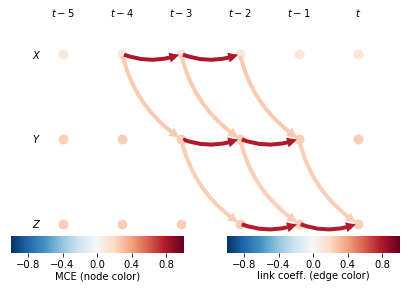

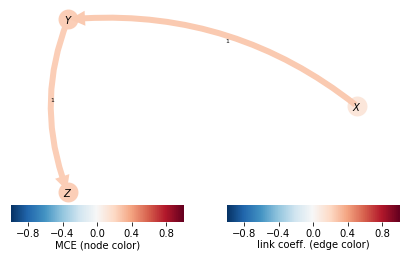

In [72]:
i=0; tau=4; j=2
graph_data = med.get_mediation_graph_data(i=i, tau=tau, j=j)
tp.plot_mediation_time_series_graph(
    var_names=var_names,
    path_node_array=graph_data['path_node_array'],
    tsg_path_val_matrix=graph_data['tsg_path_val_matrix']
    )
tp.plot_mediation_graph(
                    var_names=var_names,
                    path_val_matrix=graph_data['path_val_matrix'], 
                    path_node_array=graph_data['path_node_array'],
                    )

In both plots, the node color depicts the mediation of a variable and the link colors depict the link coefficients. The graph plot in the bottom panel is easier to visualize for more complex pathways, but it's harder to see the pathways across variables *and* in time.

Causal effect and mediation analysis can also be used for more aggregate measures. The Average Causal Effect (ACE) quantifies how strong the effect of a single variable on the whole system is and the Average Causal Susceptibility (ACS) quantifies how strong a single variable is effected by perturbations entering elsewhere in the system. Last, the Average Mediated Causal Effect (AMCE) quantifies how much a single variable mediates causal effects between any two other processes. In Runge et al, Nature Communications (2015), these measures are compared with conventional complex network measures to show that causal effect measures are better interpretable alternatives. For example, *betweenness centrality* gives the average number of shortest paths going through a particular node. However, causal effects do not necessarily take shortest paths and betweenness also does not properly take into account the causal effect weights.

In [73]:
print ("Average Causal Effect X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_ace()))
print ("Average Causal Susceptibility X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_acs()))
print ("Average Mediated Causal Effect X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_amce()))

Average Causal Effect X=0.39, Y=0.24, Z=0.00 
Average Causal Susceptibility X=0.00, Y=0.27, Z=0.36 
Average Mediated Causal Effect X=0.00, Y=0.12, Z=0.00 


Note that per default self-loops are excluded in these measures.

# 10. Prediction

Tigramite also contains a class ``tigramite.models.Prediction`` to perform predictions based on the sklearn models. The ``Prediction`` class includes a wrapper around ``run_pc_stable`` from the ``PCMCI`` class to perform predictor selection. Consider the following data generation process: 

In [74]:
numpy.random.seed(42)
T = 150
links_coeffs = {0: [((0, -1), 0.6)],
                1: [((1, -1), 0.6), ((0, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -1), 0.7)],  # ((0, -1), c)],
                }
data, true_parents = pp.var_process(links_coeffs, T=T)
dataframe = pp.DataFrame(data)

We initialize the ``Prediction`` class with ``cond_ind_model=ParCorr``. Optional test parameters can be passed on by ``cond_ind_params``. Secondly, we choose ``sklearn.linear_model.LinearRegression`` here for prediction. Also here, parameters can be passed on via ``prediction_model_params``. Last, we scale the data via ``data_transform``. The class takes care of rescaling the data for prediction. The parameters ``train_indices`` and ``test_indices`` are used to divide the data up into a training set and test set. The test set is optional since new data can be supplied later. The training set is used to select predictors and fit the model.

In [75]:
pred = Prediction(dataframe=dataframe,
        cond_ind_model=ParCorr,   #CMIknn ParCorr
#         cond_ind_params = {'knn':0.1, 'significance':'fixed_thres', 'fixed_thres':0.01},
        prediction_model = sklearn.linear_model.LinearRegression,
#         prediction_model = sklearn.gaussian_process.GaussianProcessRegressor,
        # prediction_model = sklearn.neighbors.KNeighborsRegressor,
    # prediction_model_params={'fit_intercept':False},
    # prediction_model_params = {'n_neighbors':5},
#     prediction_model_params = {'alpha':0., 'kernel':sklearn.gaussian_process.kernels.RBF() +
#                                         sklearn.gaussian_process.kernels.WhiteKernel()},
    data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
use_mask = True
mask_type = y



Now, we estimate causal predictors using ``get_predictors`` for the target variable 2 taking into account a maximum past lag of ``tau_max``. We use ``pc_alpha=None`` which optimizes the parameter based on the Akaike score. Note that the predictors are different for each prediction horizon. For example, at a prediction horizon of ``steps_ahead=1`` we get the causal parents from the model plus some others:


##
## Running Tigramite PC algorithm
##

Parameters:
selected_variables = [2]
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Variable 2

## Resulting condition sets:

    Variable 0 has 0 parent(s):

    Variable 1 has 0 parent(s):

    Variable 2 has 4 parent(s):
    [pc_alpha = 0.2]
        (2 -1): max_pval = 0.00000, min_val = 0.558
        (1 -1): max_pval = 0.00000, min_val = 0.467
        (0 -2): max_pval = 0.09687, min_val = 0.161
        (1 -2): max_pval = 0.11617, min_val = 0.152


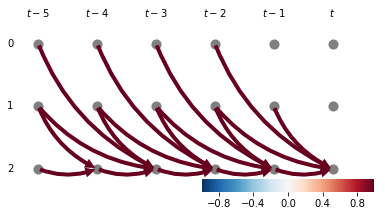

In [76]:
predictors = pred.get_predictors(
                  selected_targets=[2],
                  steps_ahead=1,
                  tau_max=5,
                  pc_alpha=None
                  )
link_matrix = numpy.zeros((3, 3, 6), dtype='bool')
for j in range(3):
    for p in predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=numpy.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    )

Note, that ``get_predictors`` is based only on the first step of PCMCI and skips the MCI step since correct false positive rates are not that relevant for prediction and the first step alone is much faster. Now, we set ``steps_ahead=2`` and get different predictors:


##
## Running Tigramite PC algorithm
##

Parameters:
selected_variables = [2]
independence test = par_corr
tau_min = 2
tau_max = 30
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Variable 2

## Resulting condition sets:

    Variable 0 has 0 parent(s):

    Variable 1 has 0 parent(s):

    Variable 2 has 3 parent(s):
    [pc_alpha = 0.05]
        (1 -2): max_pval = 0.00000, min_val = 0.598
        (0 -2): max_pval = 0.00057, min_val = 0.432
        (2 -2): max_pval = 0.03376, min_val = 0.277


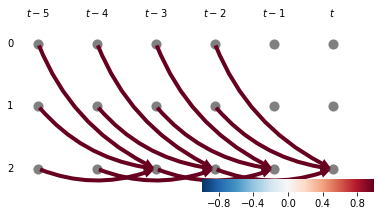

In [77]:
tau_max = 30
steps_ahead = 2
target = 2

all_predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None
                  )
link_matrix = numpy.zeros((3, 3, 6), dtype='bool')
for j in range(3):
    for p in all_predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=numpy.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    )

These predictors now efficiently avoid overfitting in the following model fit. Here one can specify whether multiple target variables should be fit at once (assuming that for all of these predictors have been estimated beforehand).

In [78]:
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)

<tigramite.models.Prediction instance at 0x7efedfdabe60>

Now we are ready to predict the target variable at the test samples:


##
## Predicting target 2
##


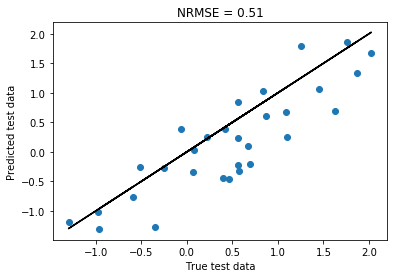

In [79]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (numpy.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

We can also predict other new data by supplying a new dataframe to ``new_data``. Because we have more samples here, the estimate of NRMSE is more reliable.


##
## Predicting target 2
##


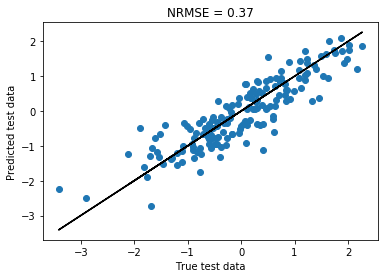

In [80]:
new_data = pp.DataFrame(pp.var_process(links_coeffs, T=200)[0])
predicted = pred.predict(target, new_data=new_data)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (numpy.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

This prediction is much better than using *all* past variables which leads to overfitting:


##
## Predicting target 2
##


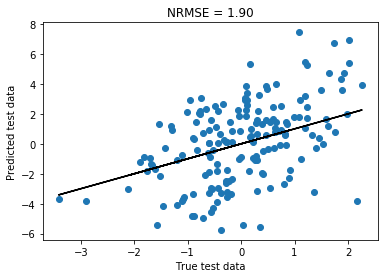

In [81]:
whole_predictors = {2:[(i, -tau) for i in range(3) for tau in range(1, tau_max+1)]}
pred.fit(target_predictors=whole_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)

# new_data = pp.DataFrame(pp.var_process(links_coeffs, T=100)[0])
predicted = pred.predict(target, new_data=new_data)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (numpy.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


Before, we rescaled the data before fitting which requires us to also rescale the test data. We can also leave the data unscaled:


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
use_mask = True
mask_type = y


##
## Predicting target 2
##


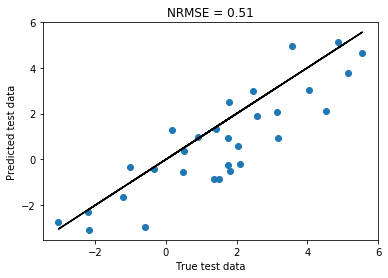

In [82]:
pred = Prediction(dataframe=dataframe,
        cond_ind_model=ParCorr,   #CMIknn ParCorr
#         cond_ind_params = {'knn':0.1, 'significance':'fixed_thres', 'fixed_thres':0.01},
        prediction_model = sklearn.linear_model.LinearRegression,
#         prediction_model = sklearn.gaussian_process.GaussianProcessRegressor,
        # prediction_model = sklearn.neighbors.KNeighborsRegressor,
    # prediction_model_params={'fit_intercept':False},
    # prediction_model_params = {'n_neighbors':5},
#     prediction_model_params = {'alpha':0., 'kernel':sklearn.gaussian_process.kernels.RBF() +
#                                         sklearn.gaussian_process.kernels.WhiteKernel()},
#     data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)
predicted = pred.predict(target)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (numpy.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


Note the different scales on the x- and y-axes.

Last, let's try out a Gaussian process regressor in conjunction with a GPDC predictor selection. Here we supply ``cond_ind_params`` and ``prediction_model_params`` because the sklearn defaults don't work well here.


# Initialize conditional independence test

Parameters:
independence test = gp_dc
significance = analytic
use_mask = True
mask_type = y
null_dist_filename = None
gp_version = new


##
## Running Tigramite PC algorithm
##

Parameters:
selected_variables = [2]
independence test = gp_dc
tau_min = 2
tau_max = 10
pc_alpha = 0.2
max_conds_dim = None
max_combinations = 1



## Variable 2
Null distribution for GPDC not available for deg. of freed. = 380.
Generating null distribution for df = 380. 
For faster computations, run function generate_and_save_nulldists(...) to precompute null distribution and load *.npz file with argument null_dist_filename

## Resulting condition sets:

    Variable 0 has 0 parent(s):

    Variable 1 has 0 parent(s):

    Variable 2 has 4 parent(s):
        (1 -2): max_pval = 0.00000, min_val = 0.266
        (0 -2): max_pval = 0.00000, min_val = 0.112
        (2 -2): max_pval = 0.00000, min_val = 0.050
        (0 -4): max_pval = 0.13600, min_val = 0.010

##
## Pred

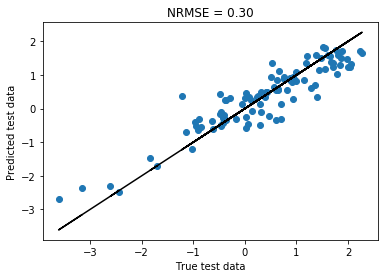

In [83]:
tau_max = 10
steps_ahead = 2
target = 2
T = 500
dataframe = pp.DataFrame(pp.var_process(links_coeffs, T=T)[0])
pred = Prediction(dataframe=dataframe,
        cond_ind_model=GPDC,   #CMIknn ParCorr
#         cond_ind_params = {'knn':0.1, 'significance':'fixed_thres', 'fixed_thres':0.01},
#         cond_ind_params = {'gp_params':{'alpha':0., 'kernel':sklearn.gaussian_process.kernels.RBF() +
#                                         sklearn.gaussian_process.kernels.WhiteKernel()}},
#         prediction_model = sklearn.linear_model.LinearRegression,
        prediction_model = sklearn.gaussian_process.GaussianProcessRegressor,
        # prediction_model = sklearn.neighbors.KNeighborsRegressor,
    # prediction_model_params={'fit_intercept':False},
    # prediction_model_params = {'n_neighbors':5},
    prediction_model_params = {'alpha':0., 'kernel':sklearn.gaussian_process.kernels.RBF() +
                                        sklearn.gaussian_process.kernels.WhiteKernel()},
    data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )

all_predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=0.2
                  )
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)
predicted = pred.predict(target)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (numpy.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
